# Riemannian mean-shift algorithm

This sumbission aims to add another clustering algorithm to Geomstats – a Riemannian version of the [mean-shift algorithm](https://en.wikipedia.org/wiki/Mean_shift). 

Classic (Euclidean) mean shift works by sliding a window – a ball of corresponding dimension, of initially fixed size, called **bandwidth**, over the point cloud, each time adjusting the center of the window:

![](https://miro.medium.com/max/648/1*bkFlVrrm4HACGfUzeBnErw.gif)

_(This and other gifs were taken from [this post on Medium](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68) by George Selif)_

The adjustment, as is clear from the name, is to make the new location of the center equal to the mean of the points around it:

$$\mathbf{c}_\text{new} = \frac{\sum_{i}K(\mathbf{x}_i-\mathbf{c})\,\mathbf{x}_i}{\sum_{i}K(\mathbf{x}_i-\mathbf{c})}$$

where $K(x)$ is the **kernel** (basically, weighting) function, for which there are [many options](https://en.wikipedia.org/wiki/Kernel_(statistics)). If the kernel is finite (Gaussian kernel, for example, is formally not), only terms from the bandwidth-size ball take part in averaging (have nonzero weights).

There are works attempting to generalize the mean shift to the case of arbitrary Riemannian manifold. To name a few:

1. **Semi-intrinsic Mean Shift on Riemannian Manifolds,** R. Caseiro et. al.
[(link)](https://www.robots.ox.ac.uk/~joao/publications/ECCV2012_RuiCaseiro.pdf)

2. **Nonlinear Mean Shift over Riemannian Manifolds,** R. Subbarao, P. Meer
[(link)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.157.1827&rep=rep1&type=pdf)

There are two ways to do this generalization – **intrinsic** and **extrinsic** ones. Extrinsic means that the shift 

$$\text{shift}=\mathbf{c}_\text{new}-\mathbf{c}_\text{old}$$

is computed extrinsically, in the Euclidean space the manifold is embedded in, and then taken onto a manifold by the exponential map. While this can be done well for Lie groups, for arbitrary Riemannian manifolds this is not so straightforward.

This submission provides a naïve version of Riemannian mean shift that simply uses the (weighted) Frechet mean, already implemented in Geomstats: the new position of the sliding window center is simply

$$\mathbf{c}_\text{new} =\text{FrechetMean}\left(\{\mathbf{x}_i\}_{i:\,d_M(\mathbf{x}_i,\mathbf{c}_\text{old})},~\text{weights}=K\left(\frac{d_M(\mathbf{x}_i,\mathbf{c}_\text{old})}{\text{bandwidth}}\right)\right)$$

So the iterations are:

1. Compute the distances over the manifold $M$, $d_M(x_i,c_\text{old})$ – this can be done in parallel, alike the `dist_pairwise(n_jobs=n_jobs)` method of `RiemannianMetric`.

2. Get the indices of the points that are not further than bandwidth away from $c_\text{old}$ – only these will take part in Frechet-averaging. So even if the kernel function is infinite, picking a proper bandwidth protects from averaging too many points.

3. Compute the weights of the points – $K\left(d_M(\mathbf{x}_i,\mathbf{c}_\text{old})/\text{bandwidth}\right),$ where $K(x)$ is the kernel function. Then normalize so they add to 1. 

For now, only flat kernel is implemented, but it is straightforward to add other kernels – weights are computed as a `numpy`-arrray, so `numpy`-ufuncs can make this computation simple and quick.

So, setting up a Riemannian mean shift, one specifies the manifold, the metric, the bandwidth. When calling the `.fit()` method, one specifies `n_centers` – the number of cluster-center-candidates, that shift towards "true" cluster centers. 

The **advantage** of mean shift (as **compared to k-means**, for example) is that it does not require the number of clusters to be found – it discovers them "automatically". Of course, nothing comes for free, and one has to pick a good bandwidth.

![](https://miro.medium.com/max/864/1*vyz94J_76dsVToaa4VG1Zg.gif)

One also has to properly pick the **initial positions** of the centers. For that, two options are implemented:

1. Randomly choosing from the points provided.
2. Sampling from the manifold. If the manifold is compact, one can sample uniformly from it.

This is controlled by the `init_centers = 'from_points'/'random_uniform'` argument of the `.fit()` method, which is set to `from_points` by default.

An interesting property of the mean shift, as can be seen from the above gif, is that "the larger the cluster – the more centers converge to its center". If the centers positions that are returned by the algorithm are not unique, the number of centers that converged to this cluster's center is a "proxy" of the **cluster's size** (if the points were sampled uniformly from the manifold).

## Experiment 1: Sphere

Prepare the setup (as in the Geomstats [K-means tutorial](https://geomstats.github.io/notebooks/05_riemannian_kmeans.html#)):

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA

np.random.seed(1)
gs.random.seed(1000)

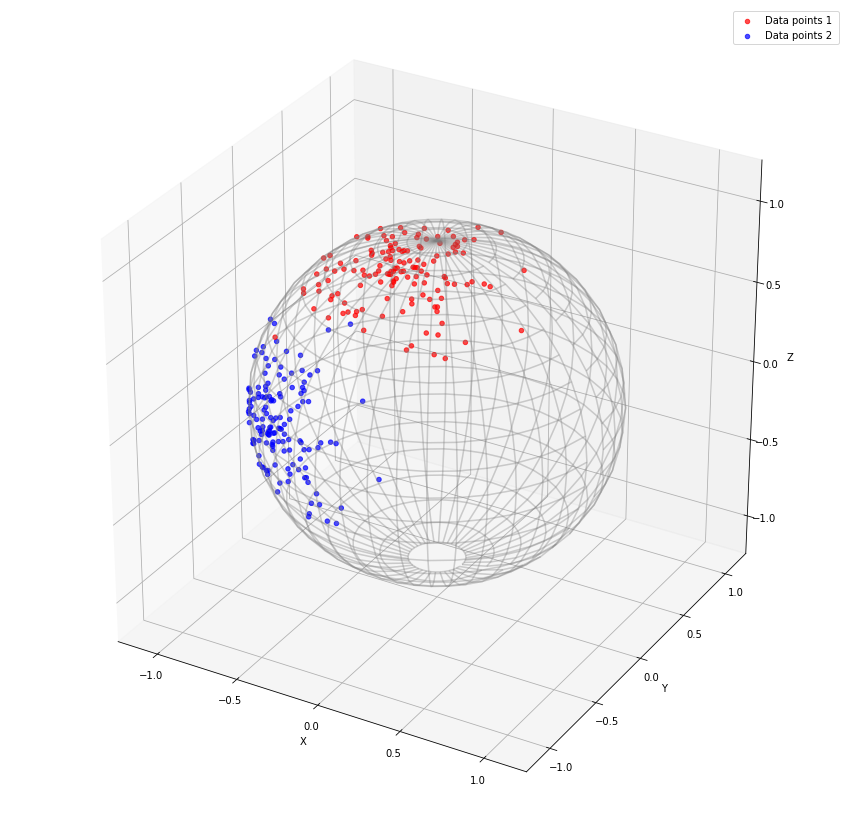

In [15]:
sphere = Hypersphere(dim=2)
cluster = sphere.random_von_mises_fisher(kappa=20, n_samples=140)

SO3 = SpecialOrthogonal(3)
rotation1 = SO3.random_uniform()
rotation2 = SO3.random_uniform()

cluster_1 =  cluster @ rotation1
cluster_2 =  cluster @ rotation2

fig = plt.figure(figsize=(15, 15))
ax = visualization.plot(cluster_1, space='S2', color='red', alpha=0.7, label='Data points 1 ')
ax = visualization.plot(cluster_2, space='S2', ax = ax, color='blue', alpha=0.7, label='Data points 2')
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend();

Do the mean shift:

In [16]:
from mean_shift import RiemannianMeanShift as RMS

In [27]:
rms = RMS(manifold=sphere, metric = metric, bandwidth=0.6, tol = 1e-4)

# concatenate the points so that RMS has to find the centers
rms.fit(np.concatenate((cluster_1,cluster_2)), n_centers = 6)

found_centers = rms.centers

In [29]:
found_centers

array([[-0.51112839, -0.84627277,  0.15023372],
       [-0.51112839, -0.84627277,  0.15023372],
       [-0.51112839, -0.84627277,  0.15023372],
       [-0.06948441, -0.28986327,  0.9545424 ],
       [-0.51112839, -0.84627277,  0.15023372],
       [-0.51112839, -0.84627277,  0.15023372]])

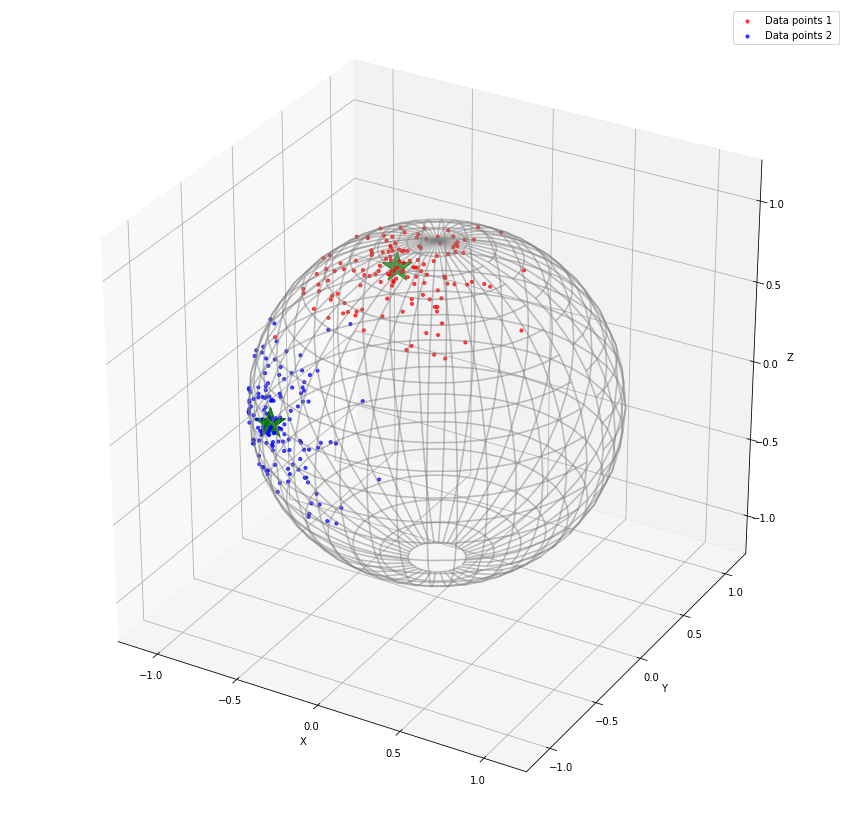

In [28]:
fig = plt.figure(figsize=(15, 15))
ax = visualization.plot(cluster_1, space='S2', color='red', alpha=0.7, s = 10, label='Data points 1 ')
ax = visualization.plot(cluster_2, space='S2', ax = ax, color='blue', alpha=0.7, s = 10, label='Data points 2')

ax = visualization.plot(found_centers, space='S2', ax = ax, color='green', alpha=0.7, marker = '*', s = 1000)

ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
ax.legend();

## Experiment 2: Hyperbolic space